![](https://i.imgur.com/sWyuy4Y.jpg)

In this notebook, I'll use the dataset "StackSample: 10% of Stack Overflow Q&A", I'll only use the questions and the tags. 
I will implement a tag suggestion system. I'll both try machine learning models and deep learning models like Word2Vec. I'll then compare the performance of both approaches. 

This notebook will be divided in 2 parts:
* PART 1 : Cleaning data and EDA
* PART 2 : Classical classifiers implemented (SGC classifier, MultiNomial Naive Bayes Classifier, Random Forest Classfier, ...


**PART 1: Cleaning Data and Exploratory Data Analysis**

**1.1 Setting up the dataset for later training**

Importing useful libraries at first

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [3]:
import os 
print(os.listdir("input"))

['Answers.csv', 'Answers.csv.zip', 'Questions.csv', 'Questions.csv.zip', 'Tags.csv', 'Tags.csv.zip']


In [4]:
# Importing the database 

df = pd.read_csv("input\\Questions.csv\\Questions.csv", encoding="ISO-8859-1")

In [5]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [6]:
tags = pd.read_csv("input\\Tags.csv\\Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [7]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [9]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


First, what I want to do is to merge both dataframes. In order to do that, I'll have to group tags by the id of the post since a post can have multiple tags. I'll just use the groupeby function and then merge the dataframes on the id. 

In [10]:
tags['Tag'] = tags['Tag'].astype(str)

In [11]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [12]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [13]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
5,330,c++ oop class nested-class
6,470,.net web-services
7,580,sql-server sql-server-2005 deployment release-...
8,650,c# visual-studio versioning
9,810,windows visual-studio registry installation


In [14]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [15]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [16]:
df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [17]:
df = df.merge(grouped_tags_final, on='Id')

In [18]:
df.head(5)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


Now, I'll take only quesions witha score greater than 5. I'm doing that for 2 reasons:
* 1- I'll require less computational resources from kaggle.
* 2- The posts will probably be with a better quality and will be better tagged since they have lots of upvotes. 


In [19]:
new_df = df[df['Score']>5]

**1.2 Cleaning Data**

Text(0.5, 1.0, 'Ratio of missing values per columns')

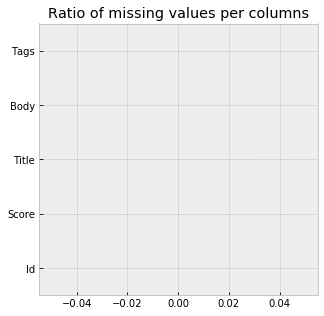

In [20]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [21]:
print('Dupplicate entries: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


This is a very good dataset since there are no missing valeus or dupplicate values. 

In [22]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

Now we only need 3 columns: Body, Title and Tags. 

**1.2.1 Tags**

Let's do some cleaning on the tags' column. Furthermore, I decided to keep the 100 most popular tags because I'll be easier to predict the right tag from 100 words than from 14,000 and because we want to keep macro tags and not be too specific since it's only a recommendation for a post, the user can add more specific tags himself. 

In [23]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [24]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [25]:
all_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [26]:
len(all_tags)

224129

In [27]:
my_set = set(all_tags)
unique_tags = list(my_set)
len(unique_tags)

14883

In [28]:
flat_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flat_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [29]:
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

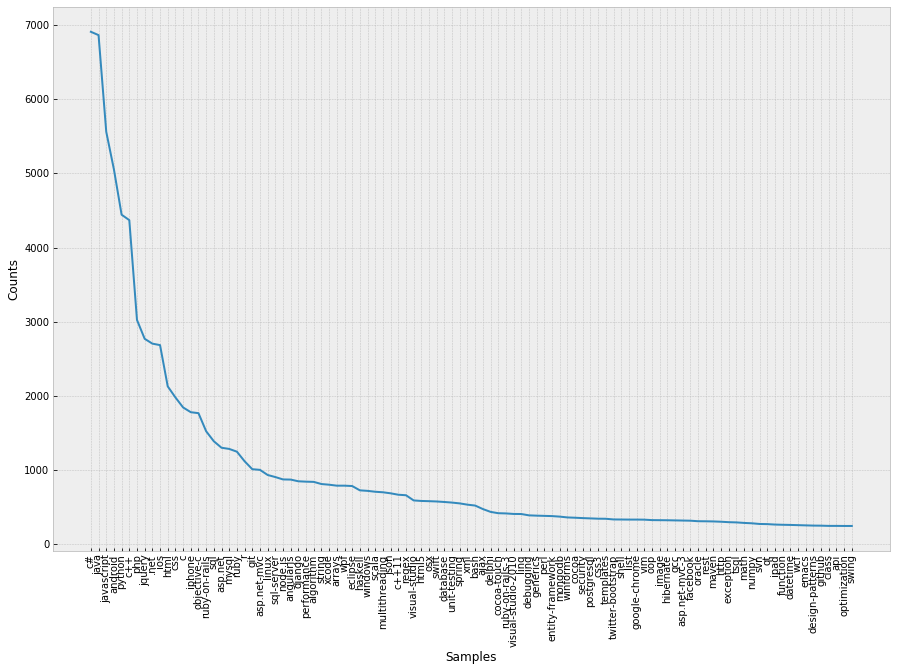

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [31]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [32]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [33]:
new_df.shape

(72950, 3)

In [34]:
new_df.dropna(subset=['Tags'], inplace=True)

In [35]:
new_df.shape

(63167, 3)

We are here loosing 10000 rows but the it's for the greater good. 

**1.2.2 Body**

In the next two columns: Body and Title, I'll use lots of text processing:
* Removing html format 
* Lowering text
* Transforming abbreviations 
* Removing punctuation (but keeping words like c# since it's the most popular tag)
* Lemmatizing words
* Removing stop words

In [36]:
# Converting html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [37]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [38]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [39]:
token=ToktokTokenizer()

In [40]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [42]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [43]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))




In [44]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [45]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [46]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Guoya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [48]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [49]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

**1.2.3 Title**

In [50]:
new_df['Title'] = new_df['Title'].apply(lambda x: str(x))
new_df['Title'] = new_df['Title'].apply(lambda x: clean_text(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: clean_punct(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: lemitizeWords(x)) 
new_df['Title'] = new_df['Title'].apply(lambda x: stopWordsRemove(x)) 

**1.3 EDA**

Here I'll just use some LDA to see if shows any paterns in words and the main topics.  

In [51]:
no_topics = 20

In [52]:
text = new_df['Body']

In [53]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [54]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [55]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(TF_IDF_matrix)

In [56]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
div function var html script class page jquery id input
--------------------------------------------
--------------------------------------------
Topic 1:
use app ios would find xcode like know android application
--------------------------------------------
--------------------------------------------
Topic 2:
00 scala font 09 01 02 tab utf-8 socket constant
--------------------------------------------
--------------------------------------------
Topic 3:
array list number data value would use like way function
--------------------------------------------
--------------------------------------------
Topic 4:
android width color height div background scroll style image top
--------------------------------------------
--------------------------------------------
Topic 5:
import python module modules def random filter statement docs 22
--------------------------------------------
--------------------------------------------
Topic 6:
b

It's a bit disappointing but I'm certain that it can be done better. 

**PART 2: Classical classifiers**

**2.1 Data preparation**

Now our data is almost ready to be put into a classifier. I just need to:
* Binarize the tags
* Use a TFIDF for body and Title
The parameters in the TFIDF are very important for the performance of our tags since we don't want him to delete words like c# or.net. To do that we need to use the following pattern : token_pattern=r"(?u)\S\S+"

In [57]:
X1 = new_df['Body']
X2 = new_df['Title']
y = new_df['Tags']

In [58]:
print(X1.shape)
print(X1[1])

(63167,)
really good tutorials explain branch merge apache subversion better specific tortoisesvn client


In [59]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)
print(y_bin)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [60]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [61]:
print('X1.SHAPE', X1.shape)
print('X2.SHAPE', X2.shape)

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)

print('X1_tfidf.SHAPE', X1_tfidf.shape)
print('X2_tfidf.SHAPE', X2_tfidf.shape)

X1.SHAPE (63167,)
X2.SHAPE (63167,)
X1_tfidf.SHAPE (63167, 1000)
X2_tfidf.SHAPE (63167, 1000)


In [62]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

Now it's finally ready. 

In [112]:
# test========================================================================================================================================
import scipy

print(X_train[0])
# print(X_train[0].todense())
print('X_train.shape', X_train.shape)
print('=========')
# print(X_train)
print('**************************')
print('y_train.shape', y_train.shape)
print(y_train[0])


# from sparse to full
X_train_sc = scipy.sparse.csr_matrix(X_train)
X_train_np = X_train_sc.A
X_train_np = X_train_np.astype(float)

y_train_sc = scipy.sparse.csr_matrix(y_train)
y_train_np = y_train_sc.A
y_train_np = y_train_np.astype(float)

X_test_sc = scipy.sparse.csr_matrix(X_test)
X_test_np = X_test_sc.A
X_test_np = X_test_np.astype(float)

y_test_sc = scipy.sparse.csr_matrix(y_test)
y_test_np = y_test_sc.A
y_test_np = y_test_np.astype(float)

  (0, 1778)	0.427696732260936
  (0, 1526)	0.5067923041014708
  (0, 1052)	0.5926728680752641
  (0, 1001)	0.45713885982738367
  (0, 760)	0.253165904389487
  (0, 522)	0.44391589560652805
  (0, 515)	0.44466332854726726
  (0, 110)	0.39315517806390265
  (0, 86)	0.4619498343032104
  (0, 3)	0.416114867886921
X_train.shape (50533, 2000)
**************************
y_train.shape (50533, 100)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## LSTM in Pytorch (Guoyao)

In [113]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as torchdata

In [148]:
class LSTMNet(nn.Module):
    '''
    input: shape [seq, batch, embedding_dim]
    output: shape [seq, batch, hidden_dim]
    '''

    def __init__(self, embedding_dim, hidden_dim, tagset_size, num_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden2tag = nn.Sequential(
                            nn.Linear(hidden_dim, 2*tagset_size),
                            nn.ReLU(inplace=True),
                            nn.Linear(2*tagset_size, tagset_size)
                          )

    def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         print('sentence.SHAPE', sentence.shape) #[bcsz, 2000]
        embeds = sentence
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=-1)
        tag_scores = F.softmax(tag_space, dim=-1)
        tag_scores = tag_space

        return tag_scores

In [149]:
# build torch dataset from numpy assay
BCSZ = 16 # batch size

X_train_tensor = torch.tensor(X_train_np).float()
y_train_tensor = torch.tensor(y_train_np).float()
dataset_train = torchdata.TensorDataset(X_train_tensor, y_train_tensor)
data_loader_train = torchdata.DataLoader(dataset_train, batch_size=BCSZ, shuffle=True)

In [151]:
EMBEDDING_DIM = 2000 # can't change
HIDDEN_DIM = 500
TAG_DIM = 100 # can't change
NUM_LAYERS = 2

LR = 1e-4
NUM_EPOCH = 100

device = torch.device('cuda:0')

lstm_net = LSTMNet(EMBEDDING_DIM, HIDDEN_DIM, TAG_DIM, NUM_LAYERS).to(device)
# loss_function = nn.NLLLoss()
# loss_function = nn.PoissonNLLLoss()
loss_function = nn.MSELoss()
# loss_function = nn.BCELoss()
# loss_function = nn.BCEWithLogitsLoss()
# loss_function = nn.MultiLabelSoftMarginLoss()
# loss_function = nn.KLDivLoss()
# loss_function = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=LR)
optimizer = optim.RMSprop(lstm_net.parameters(), lr=LR)

for epoch in range(NUM_EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
    for step, (sentence, tags) in enumerate(data_loader_train):
        
        sentence = sentence.to(device)
        tags = tags.to(device)
        
        model.zero_grad()
        
        tag_scores = lstm_net(sentence)
        
#         tags = tags.long()
        loss = loss_function(tag_scores, tags)
        loss.backward()
        optimizer.step()
        
        if (step)%(int(50533/(3*BCSZ))) == 0:
            print('EPOCH', epoch, '||', 'step', step, '||', 'loss', loss)
            
# save the model (param)
path_lstm = 'models/lstm_layer'+str(NUM_LAYERS)+'_epoch'+str(NUM_EPOCH)+'_bc'+str(BCSZ)+'_hidden'+str(HIDDEN_DIM)
torch.save(lstm_net.state_dict(), path_lstm)

EPOCH 0 || step 0 || loss tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 0 || step 1052 || loss tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 0 || step 2104 || loss tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 0 || step 3156 || loss tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 1 || step 0 || loss tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 1 || step 1052 || loss tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 1 || step 2104 || loss tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 1 || step 3156 || loss tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 2 || step 0 || loss tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 2 || step 1052 || loss tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 2 || step 2104 || loss tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 2 || step 3156 || loss tensor(0.004

EPOCH 23 || step 1052 || loss tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 23 || step 2104 || loss tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 23 || step 3156 || loss tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 24 || step 0 || loss tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 24 || step 1052 || loss tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 24 || step 2104 || loss tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 24 || step 3156 || loss tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 25 || step 0 || loss tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 25 || step 1052 || loss tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 25 || step 2104 || loss tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 25 || step 3156 || loss tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 26 || step 0 || loss 

EPOCH 46 || step 1052 || loss tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 46 || step 2104 || loss tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 46 || step 3156 || loss tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 47 || step 0 || loss tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 47 || step 1052 || loss tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 47 || step 2104 || loss tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 47 || step 3156 || loss tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 48 || step 0 || loss tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 48 || step 1052 || loss tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 48 || step 2104 || loss tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 48 || step 3156 || loss tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 49 || step 0 || loss 

EPOCH 69 || step 1052 || loss tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 69 || step 2104 || loss tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 69 || step 3156 || loss tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 70 || step 0 || loss tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 70 || step 1052 || loss tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 70 || step 2104 || loss tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 70 || step 3156 || loss tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 71 || step 0 || loss tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 71 || step 1052 || loss tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 71 || step 2104 || loss tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 71 || step 3156 || loss tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 72 || step 0 || loss 

EPOCH 92 || step 1052 || loss tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 92 || step 2104 || loss tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 92 || step 3156 || loss tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 93 || step 0 || loss tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 93 || step 1052 || loss tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 93 || step 2104 || loss tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 93 || step 3156 || loss tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 94 || step 0 || loss tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 94 || step 1052 || loss tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 94 || step 2104 || loss tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 94 || step 3156 || loss tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward>)
EPOCH 95 || step 0 || loss 

### self-defined accuracy

In [155]:
# use self-defined accuracy
from utils import accuracy as accutils
import imp
imp.reload(accutils)  # reload self-write package to make sure update

# load the saved model
print('NUM_LAYERS', NUM_LAYERS)
print('NUM_EPOCH', NUM_EPOCH)
path_lstm_reload = 'models/lstm_layer'+str(NUM_LAYERS)+'_epoch'+str(NUM_EPOCH)+'_bc'+str(BCSZ)+'_hidden'+str(HIDDEN_DIM)
lstm_net_reload = LSTMNet(EMBEDDING_DIM, HIDDEN_DIM, TAG_DIM, NUM_LAYERS)
lstm_net_reload.load_state_dict(torch.load(path_lstm_reload))
lstm_net_reload.eval()

lstm_net_cpu = lstm_net_reload
# lstm_net_cpu = lstm_net_reload.cpu()
X_test_torch = torch.from_numpy(X_test_np).float()
tag_pred_torch = lstm_net_cpu(X_test_torch)
# tag_pred_torch = tag_pred_torch.to(torch.device('cpu'))

tag_pred_np = tag_pred_torch.detach().numpy()
# tag_pred_np = np.exp(tag_pred_np)
# print('tag_pred_np', tag_pred_np)
print(np.max(tag_pred_np, axis=1))

acc = accutils.accuracy(tag_pred_np, y_test_np, 0.1)
print('ACC', acc)
# layer 1 epoch 10: 0.08603767611207852
# layer 2 epoch 10: 0.218933037834415064
# layer 4 epoch 10: 0
# layer 2 epoch 50: 0.16898844388158937

NUM_LAYERS 2
NUM_EPOCH 100
[0.12271786 0.12271786 0.12271786 ... 0.12271786 0.12271786 0.12271786]
ACC 0


### other accuracy

In [91]:
def avg_jacard_torch(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score_torch(y_pred):
#     print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard_torch(y_test, y_pred)))
#     print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")   


X_test_torch = torch.from_numpy(X_test_np).float()
# X_test_torch = X_test_torch.cuda()
# X_test_torch = X_test_torch.to(torch.device('cuda:0'))
# print(X_test_torch)
# print(model)


model_cpu = model.cpu()
tag_pred_torch = model_cpu(X_test_torch)
tag_pred_torch = tag_pred_torch.to(torch.device('cpu'))

tag_pred_np = tag_pred_torch.detach().numpy()
tag_pred_np = np.exp(tag_pred_np)
print(np.max(tag_pred_np, axis=1))

acc = print_score_torch(tag_pred_np)
print('ACC', acc)

[0.5042463  0.6366949  0.57663393 ... 0.49361384 0.9819338  0.47570148]
Jacard score: 46.862792354549384
---
ACC None


# **2.2 One vs Rest**

To evaluate our models, I'll use the jacard score since it's the best fitted for multi label classification. 

In [0]:
# def avg_jacard(y_true,y_pred):
#     '''
#     see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
#     '''
#     jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
#     return jacard.mean()*100

# def print_score(y_pred, clf):
#     print("Clf: ", clf.__class__.__name__)
#     print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
#     print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
#     print("---")    

In [ ]:
kaggle上通用的 Multi-Class Log-Loss 作为评测指标（Evaluation Metric）.

In [ ]:
# def multiclass_logloss(actual, predicted, eps=1e-15):
#     """对数损失度量（Logarithmic Loss  Metric）的多分类版本。
#     :param actual: 包含actual target classes的数组
#     :param predicted: 分类预测结果矩阵, 每个类别都有一个概率
#     """
#     # Convert 'actual' to a binary array if it's not already:
#     if len(actual.shape) == 1:
#         actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
#         for i, val in enumerate(actual):
#             actual2[i, val] = 1
#         actual = actual2

#     clip = np.clip(predicted, eps, 1 - eps)
#     rows = actual.shape[0]
#     vsota = np.sum(actual * np.log(clip))
#     return -1.0 / rows * vsota

In [0]:
# dummy = DummyClassifier()
# sgd = SGDClassifier()
# lr = LogisticRegression()
# mn = MultinomialNB()
# svc = LinearSVC()
# perceptron = Perceptron()
# pac = PassiveAggressiveClassifier()

# for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
#     clf = OneVsRestClassifier(classifier)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 2.5994136507433954
Hamming loss: 3.00411587779009
---
Clf:  SGDClassifier
Jacard score: 47.87016516278824
Hamming loss: 0.9537755263574482
---
Clf:  LogisticRegression
Jacard score: 48.3590575695214
Hamming loss: 0.9707139464935887
---
Clf:  MultinomialNB
Jacard score: 40.30181219234568
Hamming loss: 1.1750039575747981
---
Clf:  LinearSVC
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---
Clf:  Perceptron
Jacard score: 46.40045380191019
Hamming loss: 1.450292860535064
---
Clf:  PassiveAggressiveClassifier
Jacard score: 50.429641858326356
Hamming loss: 1.1897261358239672
---


**2.3 MLP Classifier**

In [0]:
# mlpc = MLPClassifier()
# mlpc.fit(X_train, y_train)

# y_pred = mlpc.predict(X_test)

# print_score(y_pred, mlpc)

Clf:  MLPClassifier
Jacard score: 48.16590907377673
Hamming loss: 1.3451796738958366
---


**2.4 Random Forest**

In [0]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train, y_train)

# y_pred = rfc.predict(X_test)

# print_score(y_pred, rfc)

Clf:  RandomForestClassifier
Jacard score: 42.38826447153185
Hamming loss: 1.06213392433117
---


**2.5 GridSearch CV on the best classifier **

In [0]:
# param_grid = {'estimator__C':[1,10,100,1000]
#               }

In [0]:
# svc = OneVsRestClassifier(LinearSVC())
# CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10, scoring=make_scorer(avg_jacard,greater_is_better=True))
# CV_svc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... estimator__C=1, score=52.33520379557779, total=  12.2s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


[CV] ......... estimator__C=1, score=52.115459818042176, total=  13.4s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV] .......... estimator__C=1, score=51.20724910128294, total=  12.3s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.8s remaining:    0.0s


[CV] .......... estimator__C=1, score=50.96741209842338, total=  12.0s
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.1s remaining:    0.0s


[CV] ........... estimator__C=1, score=51.5457813839963, total=  12.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] ......... estimator__C=10, score=48.65793156087012, total=  38.7s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s


[CV] ........ estimator__C=10, score=48.318609921459434, total=  39.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.4min remaining:    0.0s


[CV] ........ estimator__C=10, score=47.885458922858746, total=  40.3s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.0min remaining:    0.0s


[CV] .......... estimator__C=10, score=46.9340467237756, total=  39.9s
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.7min remaining:    0.0s


[CV] ........ estimator__C=10, score=47.594427638460886, total=  40.5s
[CV] estimator__C=100 ................................................
[CV] ....... estimator__C=100, score=44.844391204587104, total=  59.8s
[CV] estimator__C=100 ................................................
[CV] ....... estimator__C=100, score=44.360206897309894, total= 1.0min
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=44.04368495196634, total=  59.6s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=43.46407838813341, total=  59.8s
[CV] estimator__C=100 ................................................
[CV] ........ estimator__C=100, score=44.43610035214032, total= 1.0min
[CV] estimator__C=1000 ...............................................
[CV] ....... estimator__C=1000, score=42.80365957273051, total= 1.1min
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 15.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'estimator__C': [1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(avg_jacard), verbose=10)

In [0]:
# CV_svc.best_params_

{'estimator__C': 1}

In [0]:
# best_model = CV_svc.best_estimator_

In [0]:
# y_pred = best_model.predict(X_test)

# print_score(y_pred, best_model)

Clf:  OneVsRestClassifier
Jacard score: 52.356208115666725
Hamming loss: 0.9552794047807505
---


**2.6 Confusion matrix**

In [0]:
# for i in range(y_train.shape[1]):
#     print(multilabel_binarizer.classes_[i])
#     print(confusion_matrix(y_test[:,i], y_pred[:,i]))
#     print("")

.net
[[12033    54]
 [  447   100]]

ajax
[[12526    15]
 [   55    38]]

algorithm
[[12445    21]
 [   87    81]]

android
[[11528    40]
 [  194   872]]

angularjs
[[12443     7]
 [   49   135]]

api
[[12567    14]
 [   45     8]]

arrays
[[12405    55]
 [  103    71]]

asp.net
[[12346    30]
 [  166    92]]

asp.net-mvc
[[12402    41]
 [   99    92]]

asp.net-mvc-3
[[12566    11]
 [   44    13]]

bash
[[12520     7]
 [   46    61]]

c
[[12220    58]
 [  203   153]]

c#
[[11060   175]
 [  618   781]]

c++
[[11674    91]
 [  260   609]]

c++11
[[12453    31]
 [  103    47]]

class
[[12574    12]
 [   45     3]]

cocoa
[[12553     4]
 [   69     8]]

cocoa-touch
[[12530    10]
 [   90     4]]

css
[[12186    74]
 [  123   251]]

css3
[[12561    13]
 [   45    15]]

database
[[12503    29]
 [   84    18]]

datetime
[[12571    17]
 [   36    10]]

debugging
[[12523    27]
 [   50    34]]

delphi
[[12542     2]
 [   39    51]]

design-patterns
[[12573    11]
 [   36    14]]

django
[[1246

**2.7 Exctracting feature importance**

In [0]:
# def print_top10(feature_names, clf, class_labels):
#     """Prints features with the highest coefficient values, per class"""
#     for i, class_label in enumerate(class_labels):
#         top10 = np.argsort(clf.coef_[i])[-10:]
#         print("--------------------------------------------")
#         print("%s: %s" % (class_label,
#               " ".join(feature_names[j] for j in top10)))
#         print("--------------------------------------------")

In [0]:
# feature_names = vectorizer_X1.get_feature_names() + vectorizer_X2.get_feature_names()

In [0]:
# print_top10(feature_names, best_model, multilabel_binarizer.classes_)

--------------------------------------------
.net: determine finally sender windows mouse assembly microsoft consolewriteline .net .net
--------------------------------------------
--------------------------------------------
ajax: much 10 img request web items security load ajax ajax
--------------------------------------------
--------------------------------------------
algorithm: log input additional stick give although diff problem algorithm algorithm
--------------------------------------------
--------------------------------------------
android: webview eandroidruntime linearlayout fragment edittext intent textview activity android android
--------------------------------------------
--------------------------------------------
angularjs: resource factory integrate token config directive controller scope angular angularjs
--------------------------------------------
--------------------------------------------
api: virtual border interface retrieve deal webview docs dependency 

**If you have any comment or improvement I'm all ears. **
![](https://i.imgur.com/yO8v1sI.png)